In [1]:
import numpy as np
#import pandas as pd
import os.path
import scipy
import cv2
import sys
from lxml import etree

#from caffeutil import *
#from optimizerutil import *
from xmlutil import *

from matplotlib import pyplot as plt

import glob

from tqdm import tqdm

%matplotlib inline

In [2]:
testimg = plt.imread("TSD-FVDM/TSD-FVDM-00001/TSD-FVDM-00001-00000.png")

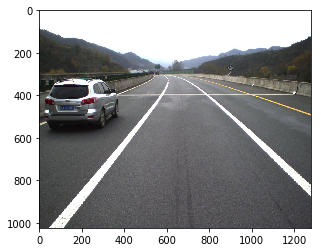

In [3]:
plt.imshow(testimg)

## Funcs

In [4]:
# tested
def get_M(xml_info):
    # Test that

    #xml_INFO = "TSD-FVDM-Info/TSD-FVDM-00001-Info.xml"
    #M_RTK = parseInfo(xml_info)
    width   = 300 # width in cm
    x_start = 400
    x_end   = 6000 # go forward in cm
    coord_3d = np.float32([
        [x_start,-width,0], [x_start, width,0],
        [x_end,  -width,0], [x_end,   width,0]
    ]).reshape(-1,3)
    #coord_6m = np.array([600., 0., 0.]).reshape(-1,3)
    BEV_coord = {
        "coord_3d":coord_3d,
        "coord_600cm" : 0,
    }
    coord_3d = BEV_coord['coord_3d']
    #coord_6m = BEV_coord['coord_600cm']

    M_RTK = parseInfo(xml_info)
    src,jac = cv2.projectPoints(coord_3d, M_RTK['R'],  M_RTK['T'], M_RTK['K'], M_RTK['D'] )
    src = src[src[:,0,:].argsort(axis=0)[:,0],0,:]
    #src_6m = cv2.projectPoints(coord_6m, M_RTK['R'],  M_RTK['T'], M_RTK['K'], M_RTK['D'] )[0][0][0]
    #print(src)

    dst = np.array([[[10,500], [10,0], [190,0], [190,500]]]).astype(np.float32)

    #src_img = testimg.copy()
    #cv2.line(src_img, tuple(src[0][0]), tuple(src[0][1]), (1,0,0), 10)
    #cv2.line(src_img, tuplesrc[0][2], src[0][3], (1,0,0), 10)

    #plt.imshow(src_img)
    #plt.show()

    M = cv2.getPerspectiveTransform(src, dst)
    
    return M

#     testimg_t = cv2.warpPerspective(testimg, M, (200,500), cv2.WARP_INVERSE_MAP)
#     plt.imshow(testimg_t)
#     plt.show()
    

In [5]:
# tested
def get_transformed_y(p1, M):
    #p1 = np.array(p1)
    p1 = np.hstack([p1, 1])
    p1v = p1.reshape(-1, 1)
    p1t = np.dot(M, p1v)
    t = p1t[2][0]
    #x = p1t[0] / t
    y = p1t[1][0] / t
    #print(x, y)
    return y

In [6]:
UNIT = 500

In [7]:
def get_ymarks(M, M_RTK):
    #M = M # TODO: change it to "get m"
    coord_mark = np.zeros([6000//UNIT-1, 3])
    coord_mark[:,0] = np.arange(1000,6001,UNIT)
    #print(coord_mark)
    #M_RTK = parseInfo(xml_INFO)
    #M = get_M(xml_INFO)
    src_mark,jac_mark = cv2.projectPoints(coord_mark, M_RTK['R'],  M_RTK['T'], M_RTK['K'], M_RTK['D'] )
    #y_marks = src_mark[:, 0, 1]
    y_marks = [get_transformed_y(src_mark[i][0], M) for i in range(src_mark.shape[0])]

    return y_marks

In [8]:
def get_ybox(box, M):
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    y_p = y + h
    x_p = x + w * 0.5
    return get_transformed_y(np.float32([x_p, y_p]), M)

In [9]:
def get_dist(y_marks, y_box):  
    dist = 6000 #init
    for i in range(6000//UNIT - 1):
        upper = y_marks[i]
        lower = y_marks[i+1]
        if lower <= y_box < upper:
            #found = True
            fraction = (upper - y_box) / (upper - lower)
            dist = UNIT * (i + fraction)
            return dist
    return dist

In [10]:
def get_iou(Reframe,GTframe):
    """
    自定义函数，计算两矩形 IOU，传入为均为矩形对角线，（x,y）  坐标。·
    """
    x1 = Reframe[0];
    y1 = Reframe[1];
    width1 = Reframe[2];
    height1 = Reframe[3];
    
    x2 = GTframe[0];
    y2 = GTframe[1];
    width2 = GTframe[2];
    height2 = GTframe[3];

    endx = max(x1+width1,x2+width2);
    startx = min(x1,x2);
    width = width1+width2-(endx-startx);

    endy = max(y1+height1,y2+height2);
    starty = min(y1,y2);
    height = height1+height2-(endy-starty);

    if width <=0 or height <= 0:
        ratio = 0 # 重叠率为 0 
    else:
        Area = width*height; # 两矩形相交面积
        Area1 = width1*height1; 
        Area2 = width2*height2;
        ratio = Area*1./(Area1+Area2-Area);
    # return IOU
    return ratio

In [11]:
def get_car_id(box, id2box):
    best_iou = 0
    best_id = -1
    for car_id in id2box:
        car_box = id2box[car_id]
        iou = get_iou(car_box, box)
        if iou > best_iou:
            best_iou = iou
            best_id = car_id
    if best_id != -1:
        return best_id
    
    return len(id2box)

In [12]:
# I may finish the test of the get_car_id
get_car_id([200,210,40,30], {0:[100,100,10,10], 1:[200,200,50,50]})

1

In [13]:
import tensorflow as tf
PATH_TO_CKPT = os.path.join('graph_ok', 'frozen_inference_graph.pb')
NUM_CLASSES = 1

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')        
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        
real_box = lambda box, w, h : (int(box[1]*w), int(box[0]*h), int(box[3]*w)-int(box[1]*w), int(box[2]*h)-int(box[0]*h))

def get_boxes(img_f, sess):
    # TODO: get boxes
    image = cv2.imread(img_f)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]
    image_np_expanded = np.expand_dims(image, axis=0)

    # 预测
    (boxes, scores, classes, num) = sess.run(
      [detection_boxes, detection_scores, detection_classes, num_detections],
      feed_dict={image_tensor: image_np_expanded})

    # 解析
    indexes = np.where(scores.flatten()>0.4)
    scores = scores.flatten()[indexes]
    boxes = np.reshape(boxes, boxes.shape[1:])[indexes]
    boxes = [real_box(box, w, h) for box in boxes]
    return boxes # [(x, y, w, h), ...]

/Users/hoijanlai/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [14]:
from tqdm import tqdm

In [15]:
def pipeline(set_num):
    xml_INFO =  "TSD-FVDM-info/TSD-FVDM-%s-info.xml"%set_num# get the path name according to the set num
    M = get_M(xml_INFO)
    y_marks_raw = get_ymarks(M, parseInfo(xml_INFO))
    
    image_files = glob.glob("TSD-FVDM/TSD-FVDM-%s/*.png"%set_num) # get the image names
    image_files = sorted(image_files, key = lambda x: int(x[-9:-4]))
    
    result = {}
    
    id2box = {}
    
    for img_f in tqdm(image_files):
        frame_num =  img_f[-9:-4]
        result[frame_num] = []
        boxes = get_boxes(img_f, sess)# TODO(Peter): output the boxes(xmin, ymin, w, h) with input of image filename 
        boxes = sorted(boxes, key = lambda x: x[2] * x[3], reverse=True)
        #y_max = plt.imread(img_f).shape[0] # better way of this?
        y_max = 500
        y_marks = np.hstack([y_max, y_marks_raw])
        used_id = []
        for box in boxes:
            car_id = get_car_id(box, id2box)
            if car_id in used_id:
                car_id = len(used_id)
            else:
                used_id.append(car_id)
            id2box[car_id] = box
            y_box = get_ybox(box, M)
            dist = get_dist(y_marks, y_box)
            dist += 400
            dist /= 100
            result[frame_num].append((car_id, box, dist)) # NOTE: append box for debugging
            
    return result
        
    

In [16]:
# target 样例 (target_id, track_id, dist)
#            (int, int, float)
from lxml import etree

def append_frame_targets_dists(root, frame_id, targets):
    for i, target in enumerate(targets):
        target_id, track_id, dist = target
        item = etree.Element("Frame%sTarget%0.5d"%(frame_id, i))
        
        id_stuff = etree.Element("ID")
        id_stuff.text = str(track_id)
        
        dist_stuff = etree.Element("Distance")
        dist_stuff.text = "%f"%dist
        
        
        item.append(id_stuff)
        item.append(dist_stuff)
        
        root.append(item)
    return root

def write_xml(result, set_name):
    root = etree.Element('opencv_storage')
    for frame_id in result:
        targets = [(i, x[0], x[2]) for i,x in enumerate(result[frame_id])]
        root = append_frame_targets_dists(root, frame_id, targets)

    # debug
    #set_name = "00091"

    with open('TSD-FVDM-%s-Result.xml'%set_name, 'w') as f:
        f.writelines(etree.tostring(root, pretty_print=True, encoding="gbk").decode("gbk"))  

    with open('TSD-FVDM-%s-Result.xml'%set_name, 'r') as f:
        lines = f.readlines()
        lines[0] = lines[0].replace('\'', '"')
    with open('TSD-FVDM-%s-Result.xml'%set_name, 'w') as f:
        f.writelines(lines)

In [17]:
# Main
set_names = glob.glob("TSD-FVDM/*")
set_names = [i[-5:] for i in set_names]
print(" ".join(set_names)) #debug
for set_name in set_names:
    result = pipeline(set_name)
    write_xml(result, set_name)

  0%|          | 0/120 [00:00<?, ?it/s]

00091 00054 00001 00024 00079 00084 00059 00042 00016 00081


100%|██████████| 62/62 [00:17<00:00,  3.51it/s]


XMLSyntaxError: Unsupported encoding zh_CN.UTF-8, line 1, column 43 (TSD-FVDM-00024-info.xml, line 1)

In [19]:
# debug
def mse(dists_1, dists_2):
    if len(dists_1) > len(dists_2):
        dists_1, dists_2 = dists_2, dists_1
    se = []
    for d1 in dists_1:
        best_se = 999
        best_d2 = -1
        for d2 in dists_2:
            err = (d2 - d1) ** 2
            if err < best_se:
                best_se = err
                best_d2 = d2
        se.append(best_se)
        if best_d2 != -1:
            dists_2.remove(best_d2)
    return np.mean(se)

from collections import defaultdict

def gather_dists(root):
    frame_dists = defaultdict(list)
    
    for child in root.getchildren():
        frame_id = child.tag[5:10]
        frame_dists[frame_id].append(float(child.find("Distance").text))
        
    return frame_dists
        
    
def get_mse(dists_gt, dists_pred):
    se = []
    for frame_id in dists_gt:
        se.append(mse(dists_gt[frame_id], dists_pred[frame_id]))
    return np.mean(se)
        
root_gt = etree.parse("TSD-FVDM-00001-GT.xml")
root_pred = etree.parse("TSD-FVDM-00001-Result.xml")
dists_gt = gather_dists(root_gt.getroot())
dists_pred = gather_dists(root_pred.getroot())
print("##MSE: ", get_mse(dists_gt, dists_pred))

##MSE:  nan


/Users/hoijanlai/.pyenv/versions/playground/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hoijanlai/.pyenv/versions/playground/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
